# Implémentation de Grad Cam

## Packages et lecture du code

** IMPORTANT : à changer si utilisation du CPU ou du GPU **

In [1]:
from pathlib import Path

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent.parent 
print(proj_path)

C:\Users\khale\OneDrive\Documents\Ensae\Projet stat\nlp_understanding


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
import pickle
import pandas as pd
from torch.autograd import Variable
import numpy as np

In [3]:
device = torch.device('cpu')
batch_size = 1

### Lecture de la classe `classifier3F`

In [4]:
import os
path_cnn_model_class = os.path.join(proj_path,"src","deep_nlp","embed_cnn","embcnnmodel.py")

In [5]:
class classifier3F(nn.Module):
    # TODO : remove embedding_dim using wv.shape[1]
    # define all the layers used in model
    def __init__(self, wv, no_words, embedding_dim, nb_filter, height_filter, output_dim, dropout, padded):
        # Constructor
        super().__init__()
        self.height_filter = height_filter
        self.padded = padded
        # embedding layer
        self.embedding = nn.Embedding.from_pretrained(wv)

        # Ne pas oublier d'ajouter un view !
        # Convolutionnal layer
        # it uses initialization as proposed by Kaiming et.al

        self.conv = nn.ModuleList()

        if self.padded:
            for height in height_filter:
                conv_lay = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=int(nb_filter),
                              kernel_size=(int(float(height)), embedding_dim)),
                    nn.ReLU(),
                    nn.MaxPool2d((no_words, 1), stride=1),
                )
                self.conv.append(conv_lay)
        else:
            for height in height_filter:
                conv_lay = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=int(nb_filter),
                              kernel_size=(int(float(height)), embedding_dim)),
                    nn.ReLU(),
                    nn.MaxPool2d((no_words - height + 1, 1), stride=1),
                )
                self.conv.append(conv_lay)

        self.fc = nn.Linear(len(height_filter) * nb_filter, output_dim)

        self.sm = nn.Softmax(dim=1)

        self.dp = nn.Dropout(p=dropout)

        self.params = [wv, no_words, embedding_dim, nb_filter, height_filter, output_dim, dropout, padded]

    def get_params(self):
        return self.params

    def forward(self, text):
        x = self.embedding(text)
        x = x.unsqueeze(1)
        # [nb_batch, nb_channel = 1, nb_words_in_sentences, embedding_dim]
        if self.padded:
            x_padded = [nn.ZeroPad2d((0, 0, 0, height - 1))(x) for height in self.height_filter]
            x_padded = list(zip(x_padded,self.conv))
            x = [conv(x).squeeze(2).squeeze(2) for x,conv in x_padded] #double squeeze pour enlever les axes avec 1 seul élement sauf sur le premier axe qui
            #correspond au nb_batch #Faire une fonction qui "squeeze" de manière itérative
        else:
            x = [conv(x).squeeze(2).squeeze(2) for conv in self.conv]
        x = torch.cat(tuple(x), dim=1) 
        x = self.dp(x) #doesn't change the shape of x
        x = self.fc(x)  # [nb_batch, 2]
        x = self.sm(x)
        return x

## Lecture des modèles déjà entraînés

### Lecture des données

In [6]:
path_dataset_train = os.path.join(proj_path,"data","02_intermediate","allocine_train_inter.csv")
path_dataset_valid = os.path.join(proj_path,"data","02_intermediate","allocine_valid_inter.csv")
path_dataset_test = os.path.join(proj_path,"data","02_intermediate","allocine_test_inter.csv")

train_data = pd.read_csv(path_dataset_train, dtype = "int64")
val_data = pd.read_csv(path_dataset_valid, dtype = "int64")
test_data = pd.read_csv(path_dataset_test, dtype = "int64")

train_tensor_x = torch.from_numpy(train_data.drop(columns=["label"]).to_numpy()).to(device).long()
train_tensor_y = torch.from_numpy(train_data["label"].to_numpy()).to(device).long()

val_tensor_x = torch.from_numpy(val_data.drop(columns=["label"]).to_numpy()).to(device).long()
val_tensor_y = torch.from_numpy(val_data["label"].to_numpy()).to(device).long()

test_tensor_x = torch.from_numpy(test_data.drop(columns=["label"]).to_numpy()).to(device).long()
test_tensor_y = torch.from_numpy(test_data["label"].to_numpy()).to(device).long()

train_data = TensorDataset(train_tensor_x,train_tensor_y)
test_data = TensorDataset(test_tensor_x, test_tensor_y)
valid_data = TensorDataset(val_tensor_x, val_tensor_y)

train_load = torch.utils.data.DataLoader(dataset=train_data,
                            batch_size=batch_size,
                            shuffle=False)
val_load = torch.utils.data.DataLoader(dataset= valid_data,
                            batch_size=batch_size,
                            shuffle=False)
test_load = torch.utils.data.DataLoader(dataset= test_data,
                            batch_size=batch_size,
                            shuffle=False)

### Création d'un dictionnaire contenant le vocabulaire

In [7]:
path_vocab = os.path.join(proj_path,"data","04_feature","voc.pkl")

#Embedding reading
with open(path_vocab, 'rb') as f:
    vocab = pickle.load(f)   

In [8]:
vocab_reverse = {y:x for x,y in vocab.items()}

### Lecture de l'embedding (Word2vec French) sauvegardé

In [9]:
path_embed_pytorch = os.path.join(proj_path,"data","04_feature","w2v_torch.pkl")

#Embedding reading
with open(path_embed_pytorch, 'rb') as f:
    embed_for_torch = pickle.load(f)

### Création d'un dictionnaire contenant les paramètres pour le modèle

In [10]:
params_models = {"wv": embed_for_torch,"no_words": 67,"embedding_dim":200, "nb_filter":600, "height_filter":tuple([2]), "output_dim":2, "dropout":0.6, "padded":True}

### Lecture du modèle

In [11]:
path_trained_model = os.path.join(proj_path,"data","06_models","embed_cnn","embed_cnn_classifier","embed_cnn.pt")

#Embedding reading
with open(path_trained_model, 'rb') as f:
    model_weight = pickle.load(f)

model = classifier3F(**params_models)

model.load_state_dict(model_weight)
model.eval()

classifier3F(
  (embedding): Embedding(155564, 200)
  (conv): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 600, kernel_size=(2, 200), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(67, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (sm): Softmax(dim=1)
  (dp): Dropout(p=0.6, inplace=False)
)

### Vérification

In [12]:
#Text test
test_text,_ = next(iter(test_load))
model(test_text)

tensor([[0.0107, 0.9893]], grad_fn=<SoftmaxBackward>)

In [13]:
pred_test = []
lab = []

with torch.no_grad():
  for review,label in test_load:
    pred_test.append(model(review))
    lab.append(label.float())

In [14]:
pred_test = torch.cat(pred_test).cpu()
lab = torch.cat(lab).cpu()
#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds[:,1])    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

binary_accuracy(pred_test, lab.float())

tensor(0.8643)

## GradCam

### Création de la classe GradCam

Pour l'instant, j'essaye d'implémenter GradCam uniquement pour le modèle Embedding + CNN. Je modifirai la classe plus tard pour qu'elle soit plus générale.
Il faudra peut être utiliser `test = [element for element in model.modules()]`

In [15]:
class embed_cnn_gradcam(nn.Module):
    def __init__(self, before_conv, pool, after_conv,model):
        super(embed_cnn_gradcam, self).__init__()
        
        # get the pretrained VGG19 network
        self.before_conv = before_conv
        
        # disect the network to access its last convolutional layer
        self.pool = pool
        
        # get the max pool of the features stem
        self.after_conv = after_conv
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.before_conv.embed(x)
        x = x.unsqueeze(1)
        if model.padded: #attention pb transpose ?
            x_padded = [nn.ZeroPad2d((0, 0, 0, height - 1))(x) for height in model.height_filter]
            x_padded = list(zip(x_padded,self.before_conv.conv))
            x = [conv(x).squeeze(2).squeeze(2) for x,conv in x_padded]
        else:
            x = [conv(x).squeeze(2).squeeze(2) for conv in self.before_conv.conv]
        x = x[0] #change latter    
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.pool(x)

        x = x.squeeze(2).squeeze(2) #TODO : utilisez une autre fonction récursive qui squeeze
        x = self.after_conv(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        x = self.before_conv.embed(x)
        x = x.unsqueeze(1)
        if model.padded:
            x_padded = [nn.ZeroPad2d((0, 0, 0, height - 1))(x) for height in model.height_filter]
            x_padded = list(zip(x_padded,self.before_conv.conv))
            x = [conv(x).squeeze(2).squeeze(2) for x,conv in x_padded]
        else:
            x = [conv(x).squeeze(2).squeeze(2) for conv in self.before_conv.conv]
        x = x[0] #change latter
        return x

### Application à la classe `classifier3F`

In [16]:
before_conv = nn.Sequential()
before_conv.add_module("embed", model.embedding)
before_conv.add_module("conv", [conv[:-1] for conv in model.conv.children()][0]) #Ici c'est en mode séquential alors que si on a plusieurs filtres, on est avec un ModuleList. Pb avec le forward quand on utilise
#un module list..

pool = nn.Sequential()
pool.add_module("pool",[conv[-1] for conv in model.conv.children()][0]) #~à changer quand plusieurs filtres

after_conv = nn.Sequential()
after_conv.add_module("fc", model.fc)
after_conv.add_module("sm", model.sm)
after_conv.add_module("dp", model.dp)

In [17]:
gradcam_cnn = embed_cnn_gradcam(before_conv, pool, after_conv,model)

### Applicaiton à un exemple

In [18]:
def explication(test_text, before_conv, pool, after_conv,model):
    gradcam_cnn = embed_cnn_gradcam(before_conv, pool, after_conv,model)
    pred = gradcam_cnn(test_text)
    gradcam_cnn(test_text)[0,0].backward()
    gradients = gradcam_cnn.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = gradcam_cnn.get_activations(test_text).detach()
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    res = pd.DataFrame({"index":test_text.squeeze().numpy(), "explanations":heatmap.numpy()})
    res["word"] = pd.Series([vocab_reverse.get(index, "") for index in test_text.squeeze().numpy()])
    res.sort_values(by='explanations', ascending=False, inplace = True)
    return {"resultat":res,"prob":gradcam_cnn(test_text)[0,1]}

In [19]:
#Récupère les résultats de explication et renvoie seulement les mots dont l'explnation est supérieure a un seuil
def explication_seuil(ex, seuil):
    resultat = ex["resultat"]
    mots_expliquants = list(resultat[resultat["explanations"] > seuil]["word"])
    return {"mots_expli": mots_expliquants, "prob": ex["prob"].item()}

In [38]:
res = []
explained = []
i = 0
for review,label in test_load:
    ex = explication(review,before_conv,pool,after_conv,model)
    explications_pour_plot = explication_seuil(ex,0.75)
    res.append([explications_pour_plot,label])
    i += 1
    if i % 100 == 0:
        print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100


KeyboardInterrupt: 

In [39]:
mots_plus_75 = [element[0]["mots_expli"] for element in res if element[0]["prob"] > 0.75]
mots_50_75 = [element[0]["mots_expli"] for element in res if (element[0]["prob"] > 0.5) & (element[0]["prob"] < 0.75)]
mots_25_50 = [element[0]["mots_expli"] for element in res if (element[0]["prob"] > 0.25) & (element[0]["prob"] < 0.5)]
mots_0_25 = [element[0]["mots_expli"] for element in res if (element[0]["prob"] < 0.25)]

In [44]:
mots = [element[0]["mots_expli"] for element in res]
prob = [element[0]["prob"] for element in res]

In [ ]:
#faire table ind pour les mots + prob puis faire une ACM

In [31]:
import itertools
mots_plus_75 = list(itertools.chain.from_iterable(mots_plus_75))
mots_50_75 = list(itertools.chain.from_iterable(mots_50_75))
mots_25_50 = list(itertools.chain.from_iterable(mots_25_50))
mots_0_25 = list(itertools.chain.from_iterable(mots_0_25))

<AxesSubplot:>

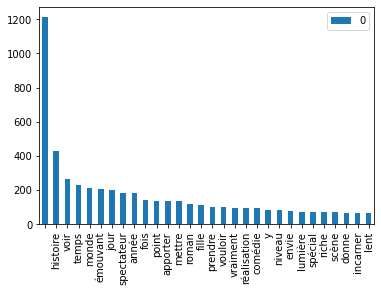

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

mots_plus_75 = pd.DataFrame.from_dict(Counter(mots_plus_75),orient="index")

mots_plus_75 = mots_plus_75.sort_values(by=0, ascending = False)

mots_plus_75.head(30).plot.bar()

<AxesSubplot:>

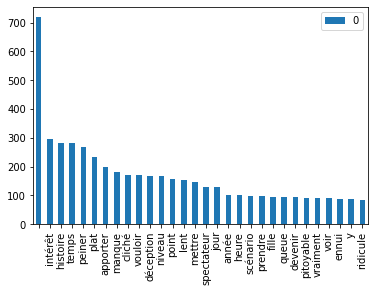

In [33]:
mots_0_25_df = pd.DataFrame.from_dict(Counter(mots_0_25),orient="index")

mots_0_25_df = mots_0_25_df.sort_values(by=0, ascending = False)

mots_0_25_df.head(30).plot.bar()

In [34]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

Nuage de mots pour les prédictions à plus de 75%

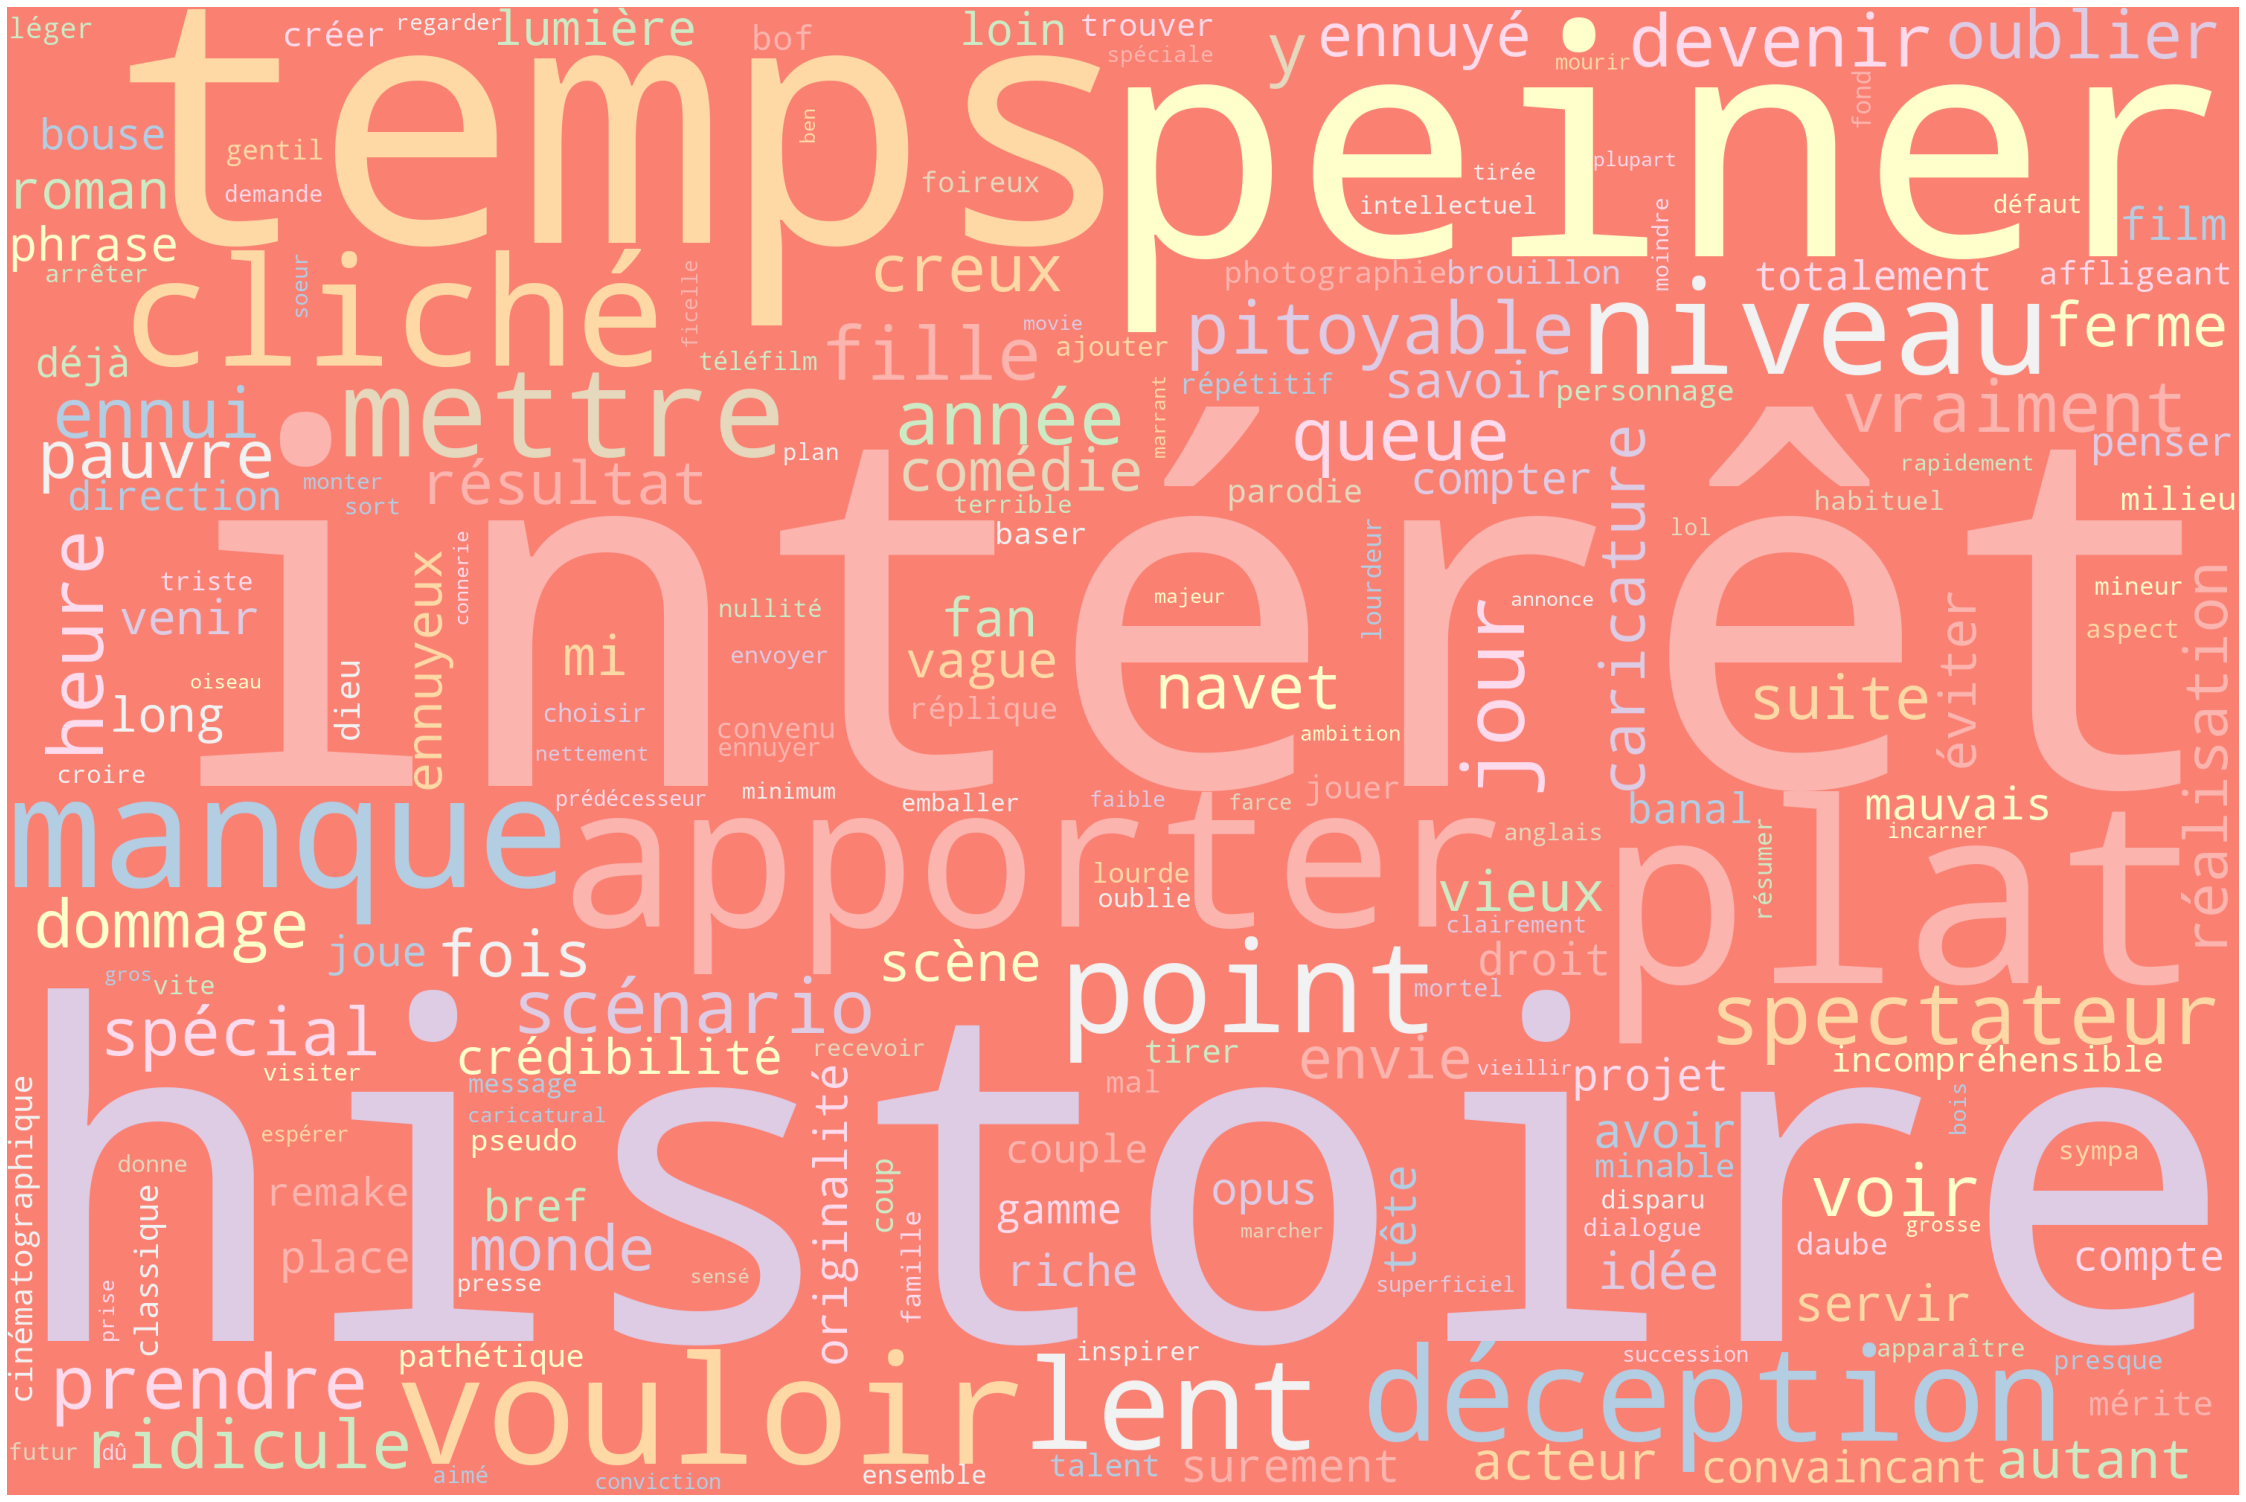

In [35]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(" ".join(mots_0_25))
# Plot
plot_cloud(wordcloud)

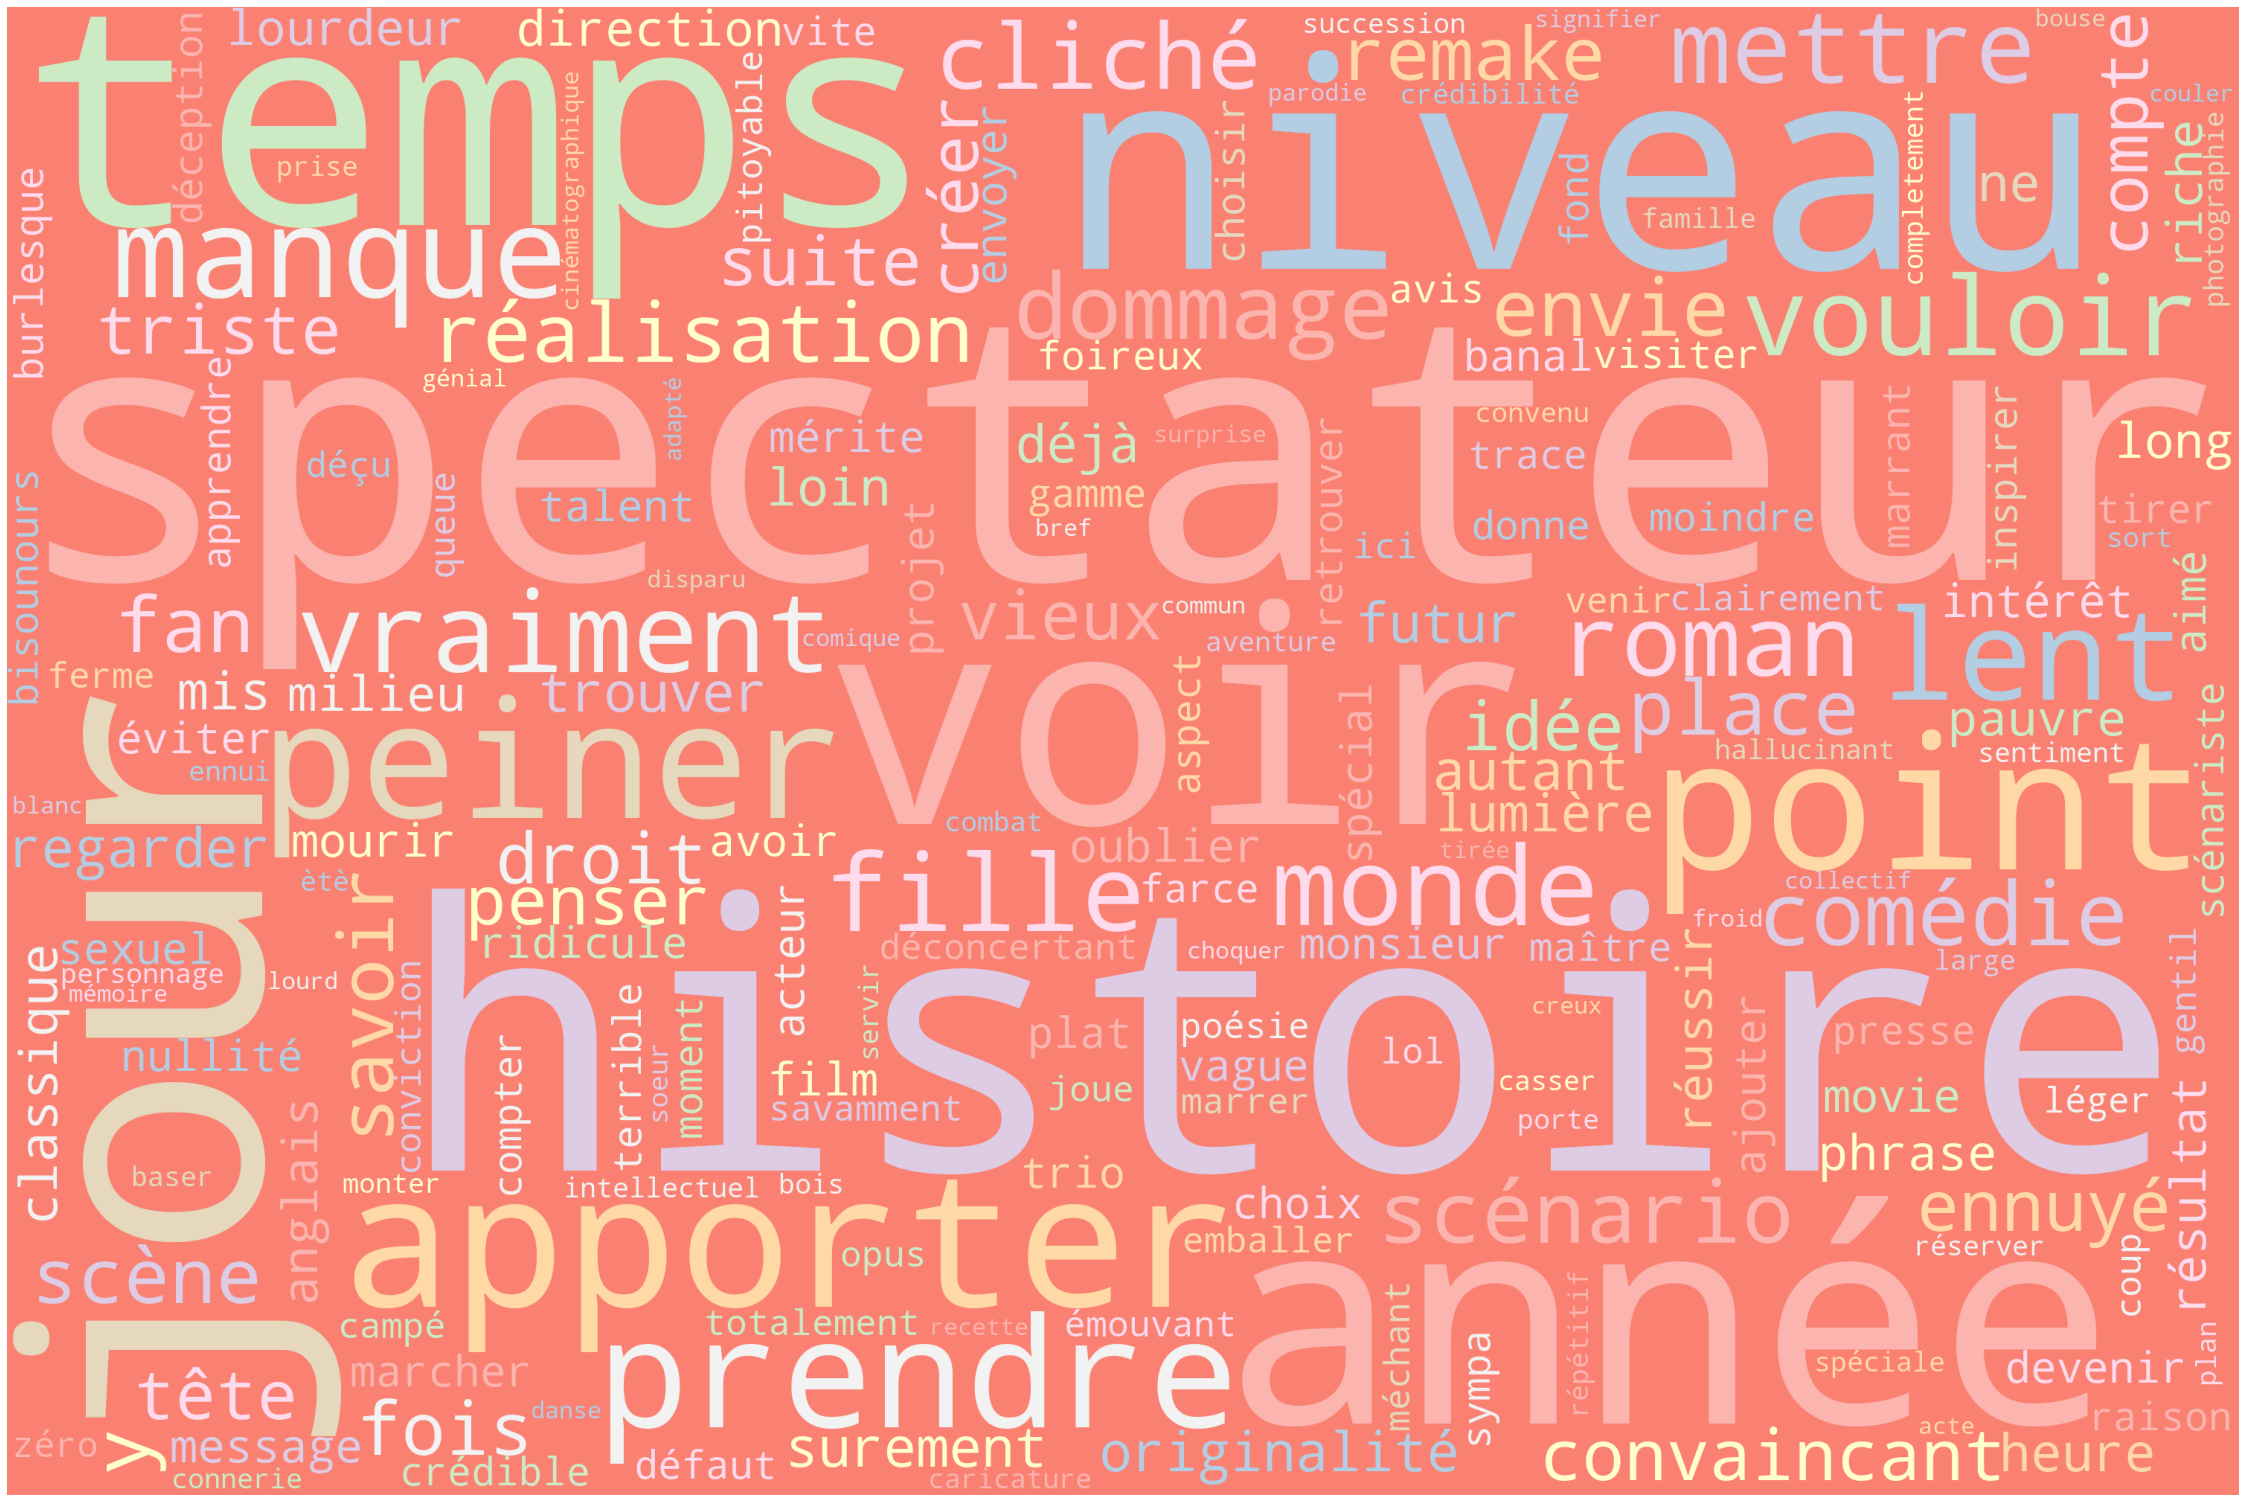

In [36]:
wordcloud2 = WordCloud(width = 3000, height = 2000, random_state=1,background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(" ".join(mots_25_50))
# Plot
plot_cloud(wordcloud2)